Florian Wilhelm
 
Principal Data Scientist
 
Cologne, Germany
 
Personal Information
 
Date of Birth 
23/11/1981
 
Place of Birth 
Neustadt an der Weinstraße, Germany
 
Marital status 
single
 
Nationality 
Germany
 
Work Experience
 
04/2016 

 
today
 
Principal Data Scientist
, 
inovex GmbH
, Cologne, Germany.
 
Consultant for Data Science, mathematical modelling and Big Data maximizing the benefits
 
of the digital transformation for our customers. Tasks:
 
_ 
building a recommendation engine and user preferenc
e service for a large e
-
commerce company
 
(mobile.de),
 
_ 
fraud and account takeover detection for a large e
-
commerce company,
 
_ 
learning to rank to improve search results of customers for a large e
-
commerce company,
 
_ 
research projects in OCR with deep learning, NLP interface for SQL, reinforcement learning
 
and uncertainty quantification,
 
_ 
project lead, support of presales activities and supervisor for bachelor and master students.
 
11/2015 

 
03/2016

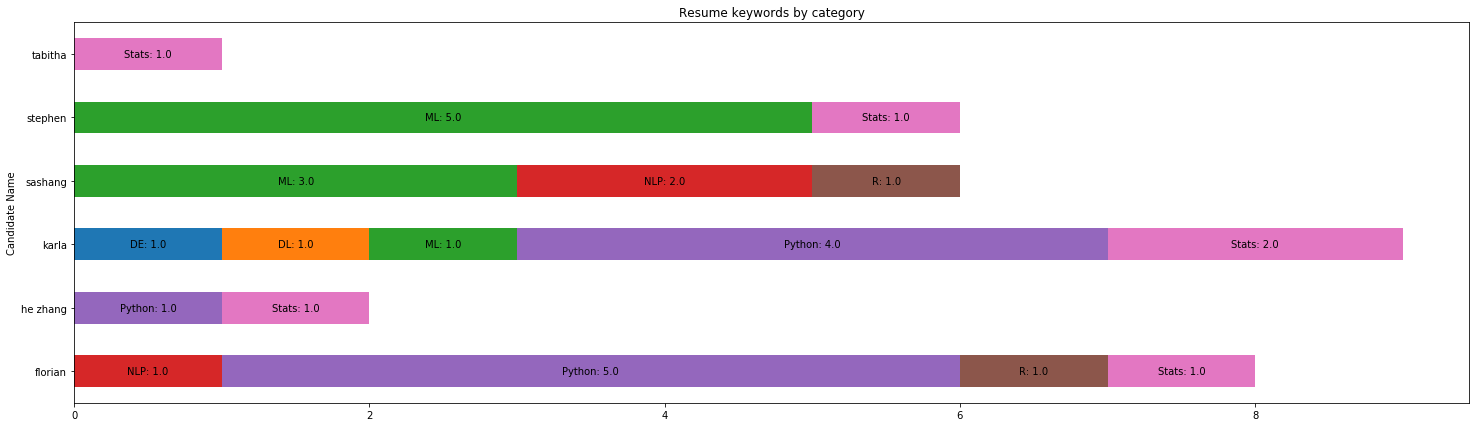

In [17]:
import PyPDF2
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.matcher import PhraseMatcher

#Function to read resumes from the folder one by one
mypath='C:/Users/Sanjay K/Music/Desktop/Resumes' #enter your path here where you saved the resumes
onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

def pdfextract(file):
    fileReader = PyPDF2.PdfFileReader(open(file,'rb'))
    countpage = fileReader.getNumPages()
    count = 0
    text = []
    while count < countpage:    
        pageObj = fileReader.getPage(count)
        count +=1
        t = pageObj.extractText()
        print (t)
        text.append(t)
    return text

#function to read resume ends


#function that does phrase matching and builds a candidate profile
def create_profile(file):
    text = pdfextract(file) 
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dict = pd.read_csv('G:/tw 1/keywords.csv')
    stats_words = [nlp(text) for text in keyword_dict['Statistics'].dropna(axis = 0)]
    NLP_words = [nlp(text) for text in keyword_dict['NLP'].dropna(axis = 0)]
    ML_words = [nlp(text) for text in keyword_dict['Machine learning'].dropna(axis = 0)]
    DL_words = [nlp(text) for text in keyword_dict['Deep learning'].dropna(axis = 0)]
    R_words = [nlp(text) for text in keyword_dict['R Language'].dropna(axis = 0)]
    python_words = [nlp(text) for text in keyword_dict['Python Language'].dropna(axis = 0)]
    Data_Engineering_words = [nlp(text) for text in keyword_dict['Data Science'].dropna(axis = 0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('R', None, *R_words)
    matcher.add('Python', None, *python_words)
    matcher.add('DE', None, *Data_Engineering_words)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    
    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
       
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)

    return(dataf)
        
#function ends
        
#code to execute/call the above functions

final_database=pd.DataFrame()
i = 0 
while i < len(onlyfiles):
    file = onlyfiles[i]
    dat = create_profile(file)
    final_database = final_database.append(dat)
    i +=1
    print(final_database)

    
#code to count words under each category and visulaize it through Matplotlib

final_database2 = final_database['Keyword'].groupby([final_database['Candidate Name'], final_database['Subject']]).count().unstack()
final_database2.reset_index(inplace = True)
final_database2.fillna(0,inplace=True)
new_data = final_database2.iloc[:,1:]
new_data.index = final_database2['Candidate Name']
#execute the below line if you want to see the candidate profile in a csv format
#sample2=new_data.to_csv('sample.csv')
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = new_data.plot.barh(title="Resume keywords by category", legend=False, figsize=(25,7), stacked=True)
labels = []
for j in new_data.columns:
    for i in new_data.index:
        label = str(j)+": " + str(new_data.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()
